In [4]:
import re
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from collections import Counter
from wordcloud import WordCloud
from wordcloud import STOPWORDS

In [5]:
!pip install -q datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 5.1 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset
emotions = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
train_set = emotions["train"]
train_set

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [9]:
train_set[0]


{'text': 'i didnt feel humiliated', 'label': 0}

In [10]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [11]:
def label_converter(row):
  return emotions["train"].features["label"].int2str(row)

In [12]:
df["label_name"]=df["label"].apply(label_converter)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [13]:
df["label_name"].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [14]:
df["label"].unique()

array([0, 3, 2, 5, 4, 1])

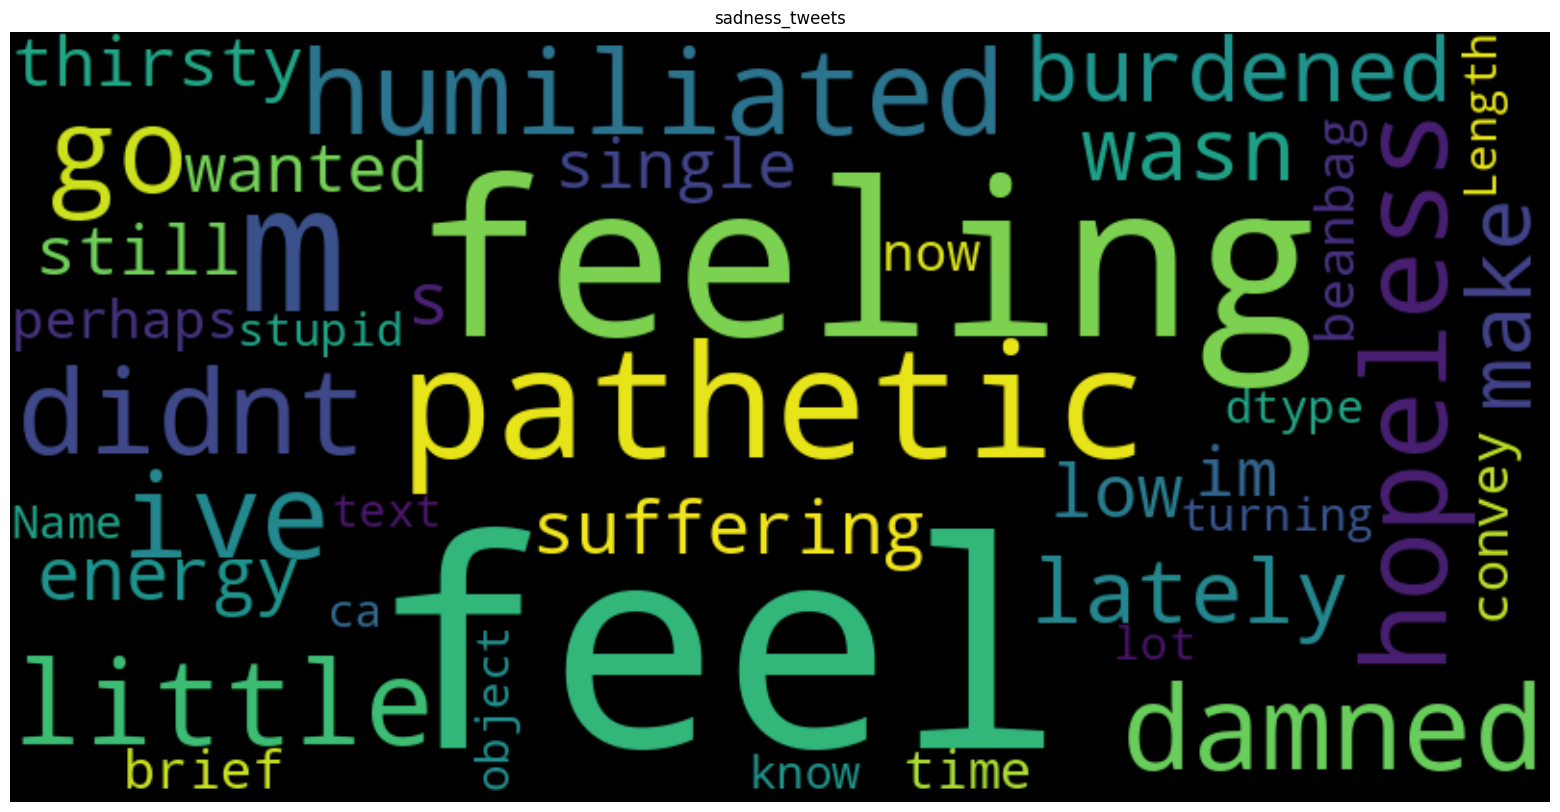

In [15]:
sadness_tweets = df['text'][df["label_name"] == 'sadness']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(width=800, height=400, background_color="black", stopwords = stop_words).generate(str(sadness_tweets))
plt.figure(figsize=[20,10])
plt.title("sadness_tweets")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

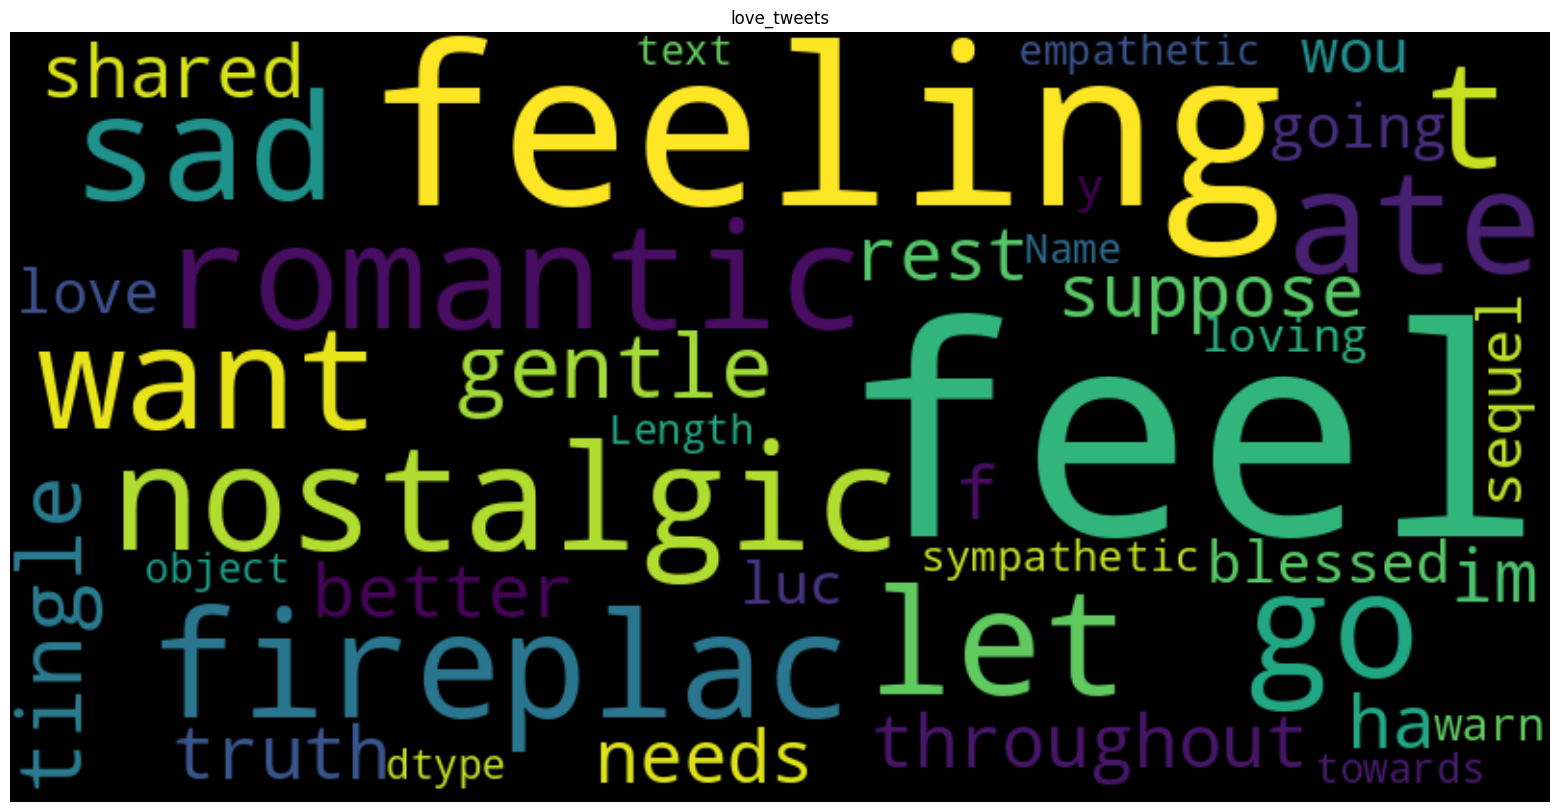

In [16]:

love_tweets = df['text'][df["label_name"] == 'love']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(width=800, height=400, background_color="black", stopwords = stop_words).generate(str(love_tweets))
plt.figure(figsize=[20,10])
plt.title("love_tweets")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [17]:
temp = df.groupby('label_name').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,label_name,text
2,joy,5362
4,sadness,4666
0,anger,2159
1,fear,1937
3,love,1304
5,surprise,572


In [18]:
fig = go.Figure(go.Funnelarea(
    text =temp.label_name,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of label_name Distribution"}
    ))
fig.show()

In [19]:
emotions.reset_format()


In [20]:
!pip install transformers

In [21]:
from transformers import AutoTokenizer

checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
  return tokenizer(batch["text"], padding = True, truncation = True)

In [22]:
print(tokenize_function(emotions["train"][:2]))


{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [23]:

tokenized_datasets = emotions.map(tokenize_function,
                                  batched = True,
                                  batch_size = None)


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [24]:
t=tokenized_datasets['train']

In [25]:
t[0]

{'text': 'i didnt feel humiliated',
 'label': 0,
 'input_ids': [101,
  1045,
  2134,
  2102,
  2514,
  26608,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0]}

In [26]:
from transformers import AutoModelForSequenceClassification
import torch

checkpoint = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = (AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                            num_labels = 6).to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds=pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [28]:
from huggingface_hub import notebook_login
notebook_login()

In [32]:
# import torch
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir = "finetuning-emotion-model",
    num_train_epochs = 2,
    learning_rate = 2e-5,
    per_device_eval_batch_size=64,
    per_device_train_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm= False,
    push_to_hub = True
)


In [34]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    tokenizer = tokenizer
)

Cloning https://huggingface.co/mohadfarag1/finetuning-emotion-model into local empty directory.


In [35]:
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.329923,0.903500,0.901947
2,0.546400,0.224985,0.922500,0.922305


TrainOutput(global_step=500, training_loss=0.5463525390625, metrics={'train_runtime': 15238.4517, 'train_samples_per_second': 2.1, 'train_steps_per_second': 0.033, 'total_flos': 720342861696000.0, 'train_loss': 0.5463525390625, 'epoch': 2.0})

In [36]:
trainer.push_to_hub(commit_message = "Training completed")


To https://huggingface.co/mohadfarag1/finetuning-emotion-model
   7f60fe8..6053e45  main -> main

   7f60fe8..6053e45  main -> main

To https://huggingface.co/mohadfarag1/finetuning-emotion-model
   6053e45..f752636  main -> main

   6053e45..f752636  main -> main



'https://huggingface.co/mohadfarag1/finetuning-emotion-model/commit/6053e459a68da66f8ccd6b272a5ea087e5e697df'

In [37]:
from transformers import pipeline

classifier = pipeline("text-classification",
                      model="mohadfarag1/finetuning-emotion-model")

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [40]:
pred = classifier(["the movie is very boring"],
                  return_all_scores = True)


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:104: UserWarning:

`return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.



In [42]:
pred

[[{'label': 'LABEL_0', 'score': 0.9640873670578003},
  {'label': 'LABEL_1', 'score': 0.006515616085380316},
  {'label': 'LABEL_2', 'score': 0.0046185520477592945},
  {'label': 'LABEL_3', 'score': 0.018825974315404892},
  {'label': 'LABEL_4', 'score': 0.0035757424775511026},
  {'label': 'LABEL_5', 'score': 0.0023768465034663677}]]

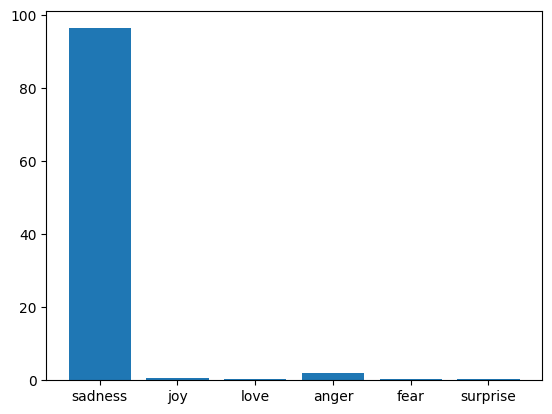

In [41]:
import pandas as pd

labels = emotions["train"].features["label"].names
df = pd.DataFrame(pred[0])
plt.bar(labels, 100 * df["score"])
plt.show()